In [1]:
import iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime
import numpy as np
import iris.coords as icoords
import iris.coord_categorisation
import iris.quickplot as qplt 
from iris.util import broadcast_to_shape
import numpy.ma as ma

In [2]:
#defining a function to calculate global average T
def area_average(cube):
    
    if cube.coord('latitude').bounds is None:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    
    grid_areas = iris.analysis.cartography.area_weights(cube)
    average = cube.collapsed(['latitude','longitude'],iris.analysis.MEAN, weights=grid_areas)
    
    return average

In [3]:
#defining a new function for time
def make_time(start):
    
    """time = "YYYY-MM" """
    
    time = pd.period_range(start=start , periods=120, freq="M") # 10 years
    time = [datetime.datetime(i.year, i.month, 16) for i in time]
    
    return time

time_1257 = make_time("1257-01") # make a time object to plot against

In [4]:
#defining function to merge cube list into single large cube
def merge_cubes(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        ensemble_coord = icoords.AuxCoord(n, standard_name='realization')
        new_cube = cube.copy()
        new_cube.add_aux_coord(ensemble_coord)
        new_cube.remove_coord('time')
        new_cube.add_dim_coord(time_coord,0)
        new_cube.remove_coord('forecast_reference_time')
        big_cube.append(new_cube)
        n+=1
    
    return big_cube.merge_cube()

In [5]:
#setting file path
dir_in_coupled = '/shared/netscratch/lrm49/Laura/'

#loading in control, july, and january runs
coupled_cntl = ['u-bu651','u-bv666','u-bv668','u-bv669','u-bv670','u-bv674','u-bv676','u-bv677','u-bv678'] 
july = ['u-bv020','u-bw758','u-bw761','u-bw762','u-bw763','u-bw764','u-bw765','u-bw766','u-bw767'] 
january = ['u-ca322', 'u-ca323', 'u-ca324', 'u-ca325', 'u-ca326', 'u-ca327', 'u-ca328', 'u-ca330','u-ca331' ]

#loading in ocean-land mask
my_mask = iris.load_cube('/shared/netscratch/lrm49/UKCA_VN112_TEST_SIMS/land_mask_bm249_da19910701_00.nc')[0,0]

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignoring netCDF variable u'surface' invalid units u'level'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))


In [6]:
#setting NH constraint
NH_constraint = iris.Constraint(latitude=lambda v: 40 <= v <= 75)

In [7]:
#Setting zero values to true to mask ocean points
no_ocean = np.logical_not(my_mask.data)

In [8]:
## JULY ## 
all_sst_cubes = iris.cube.CubeList()
for job_id in july:

    dynamic_cube = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0]
    sst_cube.data = ma.array(sst_cube.data, mask=broadcast_to_shape(no_ocean,sst_cube.shape,[1,2]))
    sst_nh = sst_cube.extract(NH_constraint)
    sst_cube_gm = area_average(sst_nh)

    all_sst_cubes.append(sst_cube_gm)

In [9]:
## JANUARY ##
all_sst_jan = iris.cube.CubeList()
for job_id_2 in january:

    control_cube = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id_2+'_dynamics_vars.nc')
    sst_control = control_cube.extract('surface_temperature')[0]
    sst_control.data = ma.array(sst_control.data, mask=broadcast_to_shape(no_ocean,sst_control.shape,[1,2]))
    sst_nh = sst_control.extract(NH_constraint)
    sst_control_jan = area_average(sst_nh)

    all_sst_jan.append(sst_control_jan)

In [10]:
## CONTROL ##
all_sst_control = iris.cube.CubeList()
for job_id_2 in coupled_cntl:

    control_cube = iris.load(dir_in_coupled+'Control/'+job_id_2+'_dynamics_vars.nc')
    sst_control = control_cube.extract('surface_temperature')[0]
    sst_control.data = ma.array(sst_control.data, mask=broadcast_to_shape(no_ocean,sst_control.shape,[1,2]))
    sst_nh = sst_control.extract(NH_constraint)
    sst_control_gm = area_average(sst_nh)

    all_sst_control.append(sst_control_gm)

In [11]:
#merging list of cubes into single large cube
one_big_sst_gm = merge_cubes(all_sst_cubes)
one_big_sst_control = merge_cubes(all_sst_control)
one_big_sst_jan = merge_cubes(all_sst_jan)

In [12]:
#Creating control ensemble average
mean_control = one_big_sst_control.collapsed('realization',iris.analysis.MEAN)

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


In [13]:
#Creating 10 year climatology
import iris.coord_categorisation
iris.coord_categorisation.add_month(mean_control,'time',name='month')
climatology_all_controls = mean_control.aggregated_by('month',iris.analysis.MEAN) 
climatology_long = np.tile(climatology_all_controls.data, 10)

In [14]:
#July surface T anomally
anomally_july = one_big_sst_gm - climatology_long 

#January Surface T anomaly
anomally_jan = one_big_sst_jan - climatology_long

In [15]:
#Taking ensemble mean anomalies for Jan and July
mean_anomally_jan = anomally_jan.collapsed('realization',iris.analysis.MEAN)
mean_anomally_july = anomally_july.collapsed('realization',iris.analysis.MEAN)

In [16]:
#Taking only the summer anomalies (May-Jun-July-Aug) 
summer_july_anomalies = []

start = mean_anomally_july[0]
summer_57_july = mean_anomally_july[4:8].collapsed('time',iris.analysis.MEAN)
summer_58_july = mean_anomally_july[16:20].collapsed('time',iris.analysis.MEAN)
summer_59_july = mean_anomally_july[28:32].collapsed('time',iris.analysis.MEAN)
summer_60_july = mean_anomally_july[40:44].collapsed('time',iris.analysis.MEAN)
summer_61_july = mean_anomally_july[52:56].collapsed('time',iris.analysis.MEAN)
summer_62_july = mean_anomally_july[64:68].collapsed('time',iris.analysis.MEAN)

summer_july_anomalies.append(start.data) 
summer_july_anomalies.append(summer_57_july.data) 
summer_july_anomalies.append(summer_58_july.data)
summer_july_anomalies.append(summer_59_july.data)
summer_july_anomalies.append(summer_60_july.data)
summer_july_anomalies.append(summer_61_july.data)
summer_july_anomalies.append(summer_62_july.data)

In [17]:
#Taking only the summer anomalies (May-Jun-July-Aug) 
summer_jan_anomalies = []

start = mean_anomally_jan[0]
summer_57_jan = mean_anomally_jan[4:8].collapsed('time',iris.analysis.MEAN)
summer_58_jan = mean_anomally_jan[16:20].collapsed('time',iris.analysis.MEAN)
summer_59_jan = mean_anomally_jan[28:32].collapsed('time',iris.analysis.MEAN)
summer_60_jan = mean_anomally_jan[40:44].collapsed('time',iris.analysis.MEAN)
summer_61_jan = mean_anomally_jan[52:56].collapsed('time',iris.analysis.MEAN)
summer_62_jan = mean_anomally_jan[64:68].collapsed('time',iris.analysis.MEAN)

summer_jan_anomalies.append(start.data) 
summer_jan_anomalies.append(summer_57_jan.data) 
summer_jan_anomalies.append(summer_58_jan.data)
summer_jan_anomalies.append(summer_59_jan.data)
summer_jan_anomalies.append(summer_60_jan.data)
summer_jan_anomalies.append(summer_61_jan.data)
summer_jan_anomalies.append(summer_62_jan.data)

In [20]:
summer_july_anomalies_3 = []

summer_57_july = mean_anomally_july[4:8].collapsed('time',iris.analysis.MEAN)
summer_58_july = mean_anomally_july[16:20].collapsed('time',iris.analysis.MEAN)
summer_59_july = mean_anomally_july[28:32].collapsed('time',iris.analysis.MEAN)
summer_60_july = mean_anomally_july[40:44].collapsed('time',iris.analysis.MEAN)
summer_61_july = mean_anomally_july[52:56].collapsed('time',iris.analysis.MEAN)
summer_62_july = mean_anomally_july[64:68].collapsed('time',iris.analysis.MEAN)
summer_63_july = mean_anomally_july[76:80].collapsed('time',iris.analysis.MEAN)
 
summer_july_anomalies_3.append(summer_57_july.data) 
summer_july_anomalies_3.append(summer_58_july.data)
summer_july_anomalies_3.append(summer_59_july.data)
summer_july_anomalies_3.append(summer_60_july.data)
summer_july_anomalies_3.append(summer_61_july.data)
summer_july_anomalies_3.append(summer_62_july.data)
summer_july_anomalies_3.append(summer_63_july.data)

In [21]:
time_ = range(0,120)

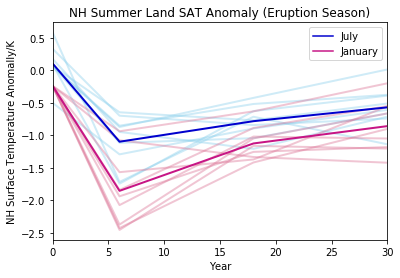

In [22]:
## PLOTTING JULY ENSEMBLES ###

for cube in anomally_july.slices_over('realization'): # loop through ensemble members
    summer_july_anomalies_2 = []

    summer_57_july_2 = cube[4:8].collapsed('time',iris.analysis.MEAN)
    summer_58_july_2 = cube[16:20].collapsed('time',iris.analysis.MEAN)
    summer_59_july_2 = cube[28:32].collapsed('time',iris.analysis.MEAN)
    summer_60_july_2 = cube[40:44].collapsed('time',iris.analysis.MEAN)
    summer_61_july_2 = cube[52:56].collapsed('time',iris.analysis.MEAN)
    summer_62_july_2 = cube[64:68].collapsed('time',iris.analysis.MEAN)
    summer_63_july_2 = cube[76:80].collapsed('time',iris.analysis.MEAN)


    summer_july_anomalies_2.append(summer_57_july_2.data) 
    summer_july_anomalies_2.append(summer_58_july_2.data)
    summer_july_anomalies_2.append(summer_59_july_2.data)
    summer_july_anomalies_2.append(summer_60_july_2.data)
    summer_july_anomalies_2.append(summer_61_july_2.data)
    summer_july_anomalies_2.append(summer_62_july_2.data)
    summer_july_anomalies_2.append(summer_63_july_2.data)

    plt.plot([time_[0], time_[6], time_[18], time_[30], time_[42], time_[54],time_[66]], 
         summer_july_anomalies_2, 
         color='skyblue', alpha = 0.4, lw=2)#plotting mean


#### PLOTTING JAN ENSEMBLES ####

for cube in anomally_jan.slices_over('realization'): # loop through ensemble members
    summer_jan_anomalies_2 = []

    start_2 = mean_anomally_jan[0]
    summer_57_jan_2 = cube[4:8].collapsed('time',iris.analysis.MEAN)
    summer_58_jan_2 = cube[16:20].collapsed('time',iris.analysis.MEAN)
    summer_59_jan_2 = cube[28:32].collapsed('time',iris.analysis.MEAN)
    summer_60_jan_2 = cube[40:44].collapsed('time',iris.analysis.MEAN)
    summer_61_jan_2 = cube[52:56].collapsed('time',iris.analysis.MEAN)
    summer_62_jan_2 = cube[64:68].collapsed('time',iris.analysis.MEAN)

    summer_jan_anomalies_2.append(start_2.data) 
    summer_jan_anomalies_2.append(summer_57_jan_2.data) 
    summer_jan_anomalies_2.append(summer_58_jan_2.data)
    summer_jan_anomalies_2.append(summer_59_jan_2.data)
    summer_jan_anomalies_2.append(summer_60_jan_2.data)
    summer_jan_anomalies_2.append(summer_61_jan_2.data)
    summer_jan_anomalies_2.append(summer_62_jan_2.data)

    plt.plot([time_[0], time_[6], time_[18], time_[30], time_[42], time_[54],time_[66]], 
         summer_jan_anomalies_2, 
         color='palevioletred', alpha = 0.4, lw=2)#plotting mean 


### PLOTTING ENSEMBLE MEANS ####
from matplotlib.lines import Line2D

plt.plot([time_[0], time_[6], time_[18], time_[30], time_[42], time_[54],time_[66]], 
         summer_july_anomalies_3, color='mediumblue',lw=2)#plotting mean

plt.plot([time_[0], time_[6], time_[18], time_[30], time_[42], time_[54],time_[66]], 
         summer_jan_anomalies, color='mediumvioletred',lw=2)#plotting mean

plt.xlim(time_[0],time_[30]) # plot only 5 years

### PLOT ADMIN #####

plt.title('NH Summer Land SAT Anomaly (Eruption Season)')
plt.xlabel('Year')
plt.ylabel('NH Surface Temperature Anomally/K')

july_line = Line2D([0], [0], label='July', color='mediumblue')
jan_line = Line2D([0], [0], label='January', color='mediumvioletred')
plt.legend(handles=[july_line, jan_line])

plt.savefig('Eruption_Timing_Global_Mean_SAT.pdf')

In [23]:
#Reading in tree rings
df = pd.read_csv("NTREND.csv")

In [24]:
#Extracting ntrend data
year = df['Year']
ntrend = df['NTREND2015']
upper_sig = df['upper2sigma']
lower_sig = df['lower2sigma']

samalas_years = year[507:513]
samalas_ntrend = ntrend[507:513]
samalas_up = upper_sig[507:513]
samalas_low = lower_sig[507:513]


In [25]:
df = pd.read_csv("Tree_Rings.csv")

year = df['%']
wil = df['Wilson']
sch = df['Schneider']
anch = df['Anchukaitis']
gui = df['Guillet']


In [26]:
wil_5yrs = wil[0:5]
wil_avg = wil_5yrs.mean()

sch_5yrs = sch[0:5]
sch_avg = sch_5yrs.mean()

anch_5yrs = anch[0:5]
anch_avg = anch_5yrs.mean()

gui_5yrs = gui[0:5]
gui_avg = gui_5yrs.mean()


In [27]:
wil_anom = []
sch_anom = []
anch_anom = []
gui_anom = []

for i in range (4, 11): 
    anomally_1 = wil[i] - wil_avg
    wil_anom.append(anomally_1)
    
    anomally_2 = sch[i] - sch_avg
    sch_anom.append(anomally_2)
    
    anomally_3 = anch[i] - anch_avg
    anch_anom.append(anomally_3)
    
    anomally_4 = gui[i] - gui_avg
    gui_anom.append(anomally_4)

In [28]:
list_56 = (wil_anom[0], sch_anom[0], anch_anom[0], gui_anom[0])
list_57 = (wil_anom[1], sch_anom[1], anch_anom[1], gui_anom[1])
list_58 = (wil_anom[2], sch_anom[2], anch_anom[2], gui_anom[2])
list_59 = (wil_anom[3], sch_anom[3], anch_anom[3], gui_anom[3])
list_60 = (wil_anom[4], sch_anom[4], anch_anom[4], gui_anom[4])
list_61 = (wil_anom[5], sch_anom[5], anch_anom[5], gui_anom[5])
list_62 = (wil_anom[6], sch_anom[6], anch_anom[6], gui_anom[6])

mean_anom = []

mean_anom.append(sum(list_56)/len(list_56))
mean_anom.append(sum(list_57)/len(list_57))
mean_anom.append(sum(list_58)/len(list_58))
mean_anom.append(sum(list_59)/len(list_59))
mean_anom.append(sum(list_60)/len(list_60))
mean_anom.append(sum(list_61)/len(list_61))
mean_anom.append(sum(list_62)/len(list_62))

sd_upper = []
sd_lower = []

sd_upper.append(mean_anom[0] + 2*np.std(list_57))
sd_lower.append(mean_anom[0] + 2*np.std(list_57)*-1)
sd_upper.append(mean_anom[1] + 2*np.std(list_58))
sd_lower.append(mean_anom[1] + 2*np.std(list_58)*-1)
sd_upper.append(mean_anom[2] + 2*np.std(list_59))
sd_lower.append(mean_anom[2] + 2*np.std(list_59)*-1)
sd_upper.append(mean_anom[3] + 2*np.std(list_60))
sd_lower.append(mean_anom[3] + 2*np.std(list_60)*-1)
sd_upper.append(mean_anom[4] + 2*np.std(list_61))
sd_lower.append(mean_anom[4] + 2*np.std(list_61)*-1)
sd_upper.append(mean_anom[5] + 2*np.std(list_62))
sd_lower.append(mean_anom[5] + 2*np.std(list_62)*-1)
sd_upper.append(mean_anom[6] + 2*np.std(list_62))
sd_lower.append(mean_anom[6] + 2*np.std(list_62)*-1)


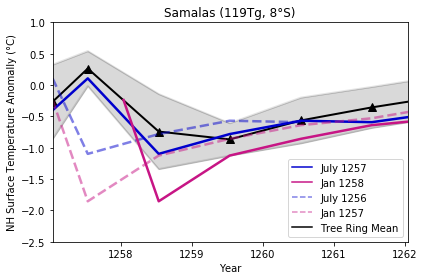

In [37]:
### PLOTTING JULY ENSEMBLES ###
plt.figure(figsize=(6,4))
for cube in anomally_july.slices_over('realization'): # loop through ensemble members
    summer_july_anomalies_2 = []

    start_2 = cube[0]
    summer_57_july_2 = cube[4:8].collapsed('time',iris.analysis.MEAN)
    summer_58_july_2 = cube[16:20].collapsed('time',iris.analysis.MEAN)
    summer_59_july_2 = cube[28:32].collapsed('time',iris.analysis.MEAN)
    summer_60_july_2 = cube[40:44].collapsed('time',iris.analysis.MEAN)
    summer_61_july_2 = cube[52:56].collapsed('time',iris.analysis.MEAN)
    summer_62_july_2 = cube[64:68].collapsed('time',iris.analysis.MEAN)

    summer_july_anomalies_2.append(start_2.data) 
    summer_july_anomalies_2.append(summer_57_july_2.data) 
    summer_july_anomalies_2.append(summer_58_july_2.data)
    summer_july_anomalies_2.append(summer_59_july_2.data)
    summer_july_anomalies_2.append(summer_60_july_2.data)
    summer_july_anomalies_2.append(summer_61_july_2.data)
    summer_july_anomalies_2.append(summer_62_july_2.data)

    


#### PLOTTING JAN ENSEMBLES ####

for cube in anomally_jan.slices_over('realization'): # loop through ensemble members
    summer_jan_anomalies_2 = []

    start_2 = mean_anomally_jan[0]
    summer_57_jan_2 = cube[4:8].collapsed('time',iris.analysis.MEAN)
    summer_58_jan_2 = cube[16:20].collapsed('time',iris.analysis.MEAN)
    summer_59_jan_2 = cube[28:32].collapsed('time',iris.analysis.MEAN)
    summer_60_jan_2 = cube[40:44].collapsed('time',iris.analysis.MEAN)
    summer_61_jan_2 = cube[52:56].collapsed('time',iris.analysis.MEAN)
    summer_62_jan_2 = cube[64:68].collapsed('time',iris.analysis.MEAN)

    summer_jan_anomalies_2.append(start_2.data) 
    summer_jan_anomalies_2.append(summer_57_jan_2.data) 
    summer_jan_anomalies_2.append(summer_58_jan_2.data)
    summer_jan_anomalies_2.append(summer_59_jan_2.data)
    summer_jan_anomalies_2.append(summer_60_jan_2.data)
    summer_jan_anomalies_2.append(summer_61_jan_2.data)
    summer_jan_anomalies_2.append(summer_62_jan_2.data)

    


#### PLOTTING TREE RING DATA ####



plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [mean_anom[0], mean_anom[1], mean_anom[2], mean_anom[3], mean_anom[4], mean_anom[5], mean_anom[6]], 
         lw = 2, color = 'black', marker= '^', markersize = 8, linestyle = '-')

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [sd_upper[0], sd_upper[1], sd_upper[2], sd_upper[3], sd_upper[4], sd_upper[5], sd_upper[6]], 
         lw = 2, color = 'black', linestyle = '-', alpha = 0.1)

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [sd_lower[0], sd_lower[1], sd_lower[2], sd_lower[3], sd_lower[4], sd_lower[5], sd_lower[6]], 
         lw = 2, color = 'black', linestyle = '-', alpha = 0.1)

plt.fill_between([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]]
                 ,[sd_upper[0], sd_upper[1], sd_upper[2], sd_upper[3], sd_upper[4], sd_upper[5], sd_upper[6]]
                 , [sd_lower[0], sd_lower[1], sd_lower[2], sd_lower[3], sd_lower[4], sd_lower[5], sd_lower[6]]
                 , color = 'black', alpha = 0.15)

### PLOTTING ENSEMBLE MEANS ####
from matplotlib.lines import Line2D

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42]], 
         [summer_july_anomalies[1], summer_july_anomalies[2], summer_july_anomalies[3], summer_july_anomalies[4], summer_july_anomalies[5]],
          color='mediumblue',lw=2.5, alpha = 0.5, linestyle = '--')#plotting mean

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54],time_1257[66]], 
         summer_july_anomalies, color='mediumblue',lw=2.5)#plotting mean

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54],time_1257[66]], 
         summer_jan_anomalies, color='mediumvioletred',lw=2.5, alpha = 0.5, linestyle = '--')#plotting mean

plt.plot([time_1257[12], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66],time_1257[78]], 
         summer_jan_anomalies, color='mediumvioletred',lw=2.5)#plotting mean

plt.xlim(time_1257[0],time_1257[60]) # plot only 5 years
plt.ylim(-2.5,1)

### PLOT ADMIN #####

plt.title('Samalas (119Tg, 8' + u"\N{DEGREE SIGN}"+ 'S)')
plt.xlabel('Year')
plt.ylabel('NH Surface Temperature Anomally (' + u"\N{DEGREE SIGN}"+ 'C)')

july_line = Line2D([0], [0], label='July 1257', color='mediumblue')
jan_line = Line2D([0], [0], label='Jan 1258', color='mediumvioletred')
july_line_2 = Line2D([0], [0], label='July 1256', color='mediumblue', alpha = 0.5, linestyle = '--')
jan_line_2 = Line2D([0], [0], label='Jan 1257', color='mediumvioletred', alpha = 0.5, linestyle = '--')
mean_line = Line2D([0], [0], label='Tree Ring Mean', color='black', linestyle = '-')
legend_1 = plt.legend(handles=[july_line, jan_line, july_line_2, jan_line_2, mean_line], loc='lower right')
#plt.legend(handles=[wil_line, sch_line, anch_line, gui_line], loc='lower right')
#plt.gca().add_artist(legend_1)
plt.tight_layout()

plt.savefig('Eruption_Timing_Global_Mean_SAT+Multiple_Tree_Rings_Simplified_Double_Jan.pdf')

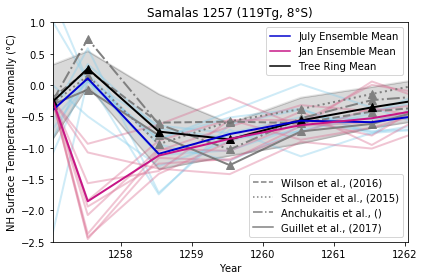

In [36]:
### PLOTTING JULY ENSEMBLES ###
plt.figure(figsize=(6,4))
for cube in anomally_july.slices_over('realization'): # loop through ensemble members
    summer_july_anomalies_2 = []

    start_2 = cube[0]
    summer_57_july_2 = cube[4:8].collapsed('time',iris.analysis.MEAN)
    summer_58_july_2 = cube[16:20].collapsed('time',iris.analysis.MEAN)
    summer_59_july_2 = cube[28:32].collapsed('time',iris.analysis.MEAN)
    summer_60_july_2 = cube[40:44].collapsed('time',iris.analysis.MEAN)
    summer_61_july_2 = cube[52:56].collapsed('time',iris.analysis.MEAN)
    summer_62_july_2 = cube[64:68].collapsed('time',iris.analysis.MEAN)

    summer_july_anomalies_2.append(start_2.data) 
    summer_july_anomalies_2.append(summer_57_july_2.data) 
    summer_july_anomalies_2.append(summer_58_july_2.data)
    summer_july_anomalies_2.append(summer_59_july_2.data)
    summer_july_anomalies_2.append(summer_60_july_2.data)
    summer_july_anomalies_2.append(summer_61_july_2.data)
    summer_july_anomalies_2.append(summer_62_july_2.data)

    plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54],time_1257[66]], 
         summer_july_anomalies_2, 
         color='skyblue', alpha = 0.4, lw=2)#plotting mean


#### PLOTTING JAN ENSEMBLES ####

for cube in anomally_jan.slices_over('realization'): # loop through ensemble members
    summer_jan_anomalies_2 = []

    start_2 = mean_anomally_jan[0]
    summer_57_jan_2 = cube[4:8].collapsed('time',iris.analysis.MEAN)
    summer_58_jan_2 = cube[16:20].collapsed('time',iris.analysis.MEAN)
    summer_59_jan_2 = cube[28:32].collapsed('time',iris.analysis.MEAN)
    summer_60_jan_2 = cube[40:44].collapsed('time',iris.analysis.MEAN)
    summer_61_jan_2 = cube[52:56].collapsed('time',iris.analysis.MEAN)
    summer_62_jan_2 = cube[64:68].collapsed('time',iris.analysis.MEAN)

    summer_jan_anomalies_2.append(start_2.data) 
    summer_jan_anomalies_2.append(summer_57_jan_2.data) 
    summer_jan_anomalies_2.append(summer_58_jan_2.data)
    summer_jan_anomalies_2.append(summer_59_jan_2.data)
    summer_jan_anomalies_2.append(summer_60_jan_2.data)
    summer_jan_anomalies_2.append(summer_61_jan_2.data)
    summer_jan_anomalies_2.append(summer_62_jan_2.data)

    plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54],time_1257[66]], 
         summer_jan_anomalies_2, 
         color='palevioletred', alpha = 0.4, lw=2)#plotting mean 



#### PLOTTING TREE RING DATA ####

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [wil_anom[0], wil_anom[1], wil_anom[2], wil_anom[3], wil_anom[4], wil_anom[5],  wil_anom[6]], 
         lw = 2, color = 'grey', marker= '^', markersize = 8, linestyle = '--')
plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [sch_anom[0], sch_anom[1], sch_anom[2], sch_anom[3], sch_anom[4], sch_anom[5], sch_anom[6]], 
         lw = 2, color = 'grey', marker= '^', markersize = 8, linestyle = ':')
plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [anch_anom[0], anch_anom[1], anch_anom[2], anch_anom[3], anch_anom[4], anch_anom[5], anch_anom[6]], 
         lw = 2, color = 'grey', marker= '^', markersize = 8, linestyle = '-.')
plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [gui_anom[0], gui_anom[1], gui_anom[2], gui_anom[3], gui_anom[4], gui_anom[5], gui_anom[6]], 
         lw = 2, color = 'grey', marker= '^', markersize = 8, linestyle = '-')

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [mean_anom[0], mean_anom[1], mean_anom[2], mean_anom[3], mean_anom[4], mean_anom[5], mean_anom[6]], 
         lw = 2, color = 'black', marker= '^', markersize = 8, linestyle = '-')

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [sd_upper[0], sd_upper[1], sd_upper[2], sd_upper[3], sd_upper[4], sd_upper[5], sd_upper[6]], 
         lw = 2, color = 'black', linestyle = '-', alpha = 0.1)

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [sd_lower[0], sd_lower[1], sd_lower[2], sd_lower[3], sd_lower[4], sd_lower[5], sd_lower[6]], 
         lw = 2, color = 'black', linestyle = '-', alpha = 0.1)

plt.fill_between([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]]
                 ,[sd_upper[0], sd_upper[1], sd_upper[2], sd_upper[3], sd_upper[4], sd_upper[5], sd_upper[6]]
                 , [sd_lower[0], sd_lower[1], sd_lower[2], sd_lower[3], sd_lower[4], sd_lower[5], sd_lower[6]]
                 , color = 'black', alpha = 0.15)

### PLOTTING ENSEMBLE MEANS ####
from matplotlib.lines import Line2D

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54],time_1257[66]], 
         summer_july_anomalies, color='mediumblue',lw=2)#plotting mean

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54],time_1257[66]], 
         summer_jan_anomalies, color='mediumvioletred',lw=2)#plotting mean

plt.xlim(time_1257[0],time_1257[60]) # plot only 5 years
plt.ylim(-2.5,1)

### PLOT ADMIN #####

plt.title('Samalas 1257 (119Tg, 8' + u"\N{DEGREE SIGN}"+ 'S)')
plt.xlabel('Year')
plt.ylabel('NH Surface Temperature Anomally (' + u"\N{DEGREE SIGN}"+ 'C)')

july_line = Line2D([0], [0], label='July Ensemble Mean', color='mediumblue')
jan_line = Line2D([0], [0], label='Jan Ensemble Mean', color='mediumvioletred')
wil_line = Line2D([0], [0], label='Wilson et al., (2016)', color='grey',linestyle = '--' )
sch_line = Line2D([0], [0], label='Schneider et al., (2015)', color='grey', linestyle = ':')
anch_line = Line2D([0], [0], label='Anchukaitis et al., ()', color='grey', linestyle = '-.')
gui_line = Line2D([0], [0], label='Guillet et al., (2017)', color='grey', linestyle = '-')
mean_line = Line2D([0], [0], label='Tree Ring Mean', color='black', linestyle = '-')
legend_1 = plt.legend(handles=[july_line, jan_line, mean_line], loc='upper right')
plt.legend(handles=[wil_line, sch_line, anch_line, gui_line], loc='lower right')
plt.gca().add_artist(legend_1)
plt.tight_layout()

plt.savefig('Eruption_Timing_Global_Mean_SAT+Multiple_Tree_Rings.pdf')

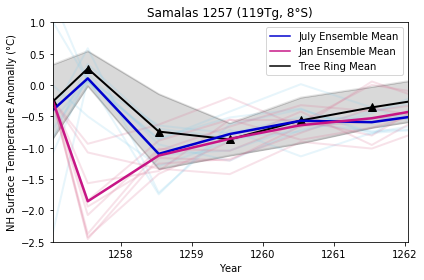

In [35]:
### PLOTTING JULY ENSEMBLES ###
plt.figure(figsize=(6,4))
for cube in anomally_july.slices_over('realization'): # loop through ensemble members
    summer_july_anomalies_2 = []

    start_2 = cube[0]
    summer_57_july_2 = cube[4:8].collapsed('time',iris.analysis.MEAN)
    summer_58_july_2 = cube[16:20].collapsed('time',iris.analysis.MEAN)
    summer_59_july_2 = cube[28:32].collapsed('time',iris.analysis.MEAN)
    summer_60_july_2 = cube[40:44].collapsed('time',iris.analysis.MEAN)
    summer_61_july_2 = cube[52:56].collapsed('time',iris.analysis.MEAN)
    summer_62_july_2 = cube[64:68].collapsed('time',iris.analysis.MEAN)

    summer_july_anomalies_2.append(start_2.data) 
    summer_july_anomalies_2.append(summer_57_july_2.data) 
    summer_july_anomalies_2.append(summer_58_july_2.data)
    summer_july_anomalies_2.append(summer_59_july_2.data)
    summer_july_anomalies_2.append(summer_60_july_2.data)
    summer_july_anomalies_2.append(summer_61_july_2.data)
    summer_july_anomalies_2.append(summer_62_july_2.data)

    plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54],time_1257[66]], 
         summer_july_anomalies_2, 
         color='skyblue', alpha = 0.2, lw=2)#plotting mean


#### PLOTTING JAN ENSEMBLES ####

for cube in anomally_jan.slices_over('realization'): # loop through ensemble members
    summer_jan_anomalies_2 = []

    start_2 = mean_anomally_jan[0]
    summer_57_jan_2 = cube[4:8].collapsed('time',iris.analysis.MEAN)
    summer_58_jan_2 = cube[16:20].collapsed('time',iris.analysis.MEAN)
    summer_59_jan_2 = cube[28:32].collapsed('time',iris.analysis.MEAN)
    summer_60_jan_2 = cube[40:44].collapsed('time',iris.analysis.MEAN)
    summer_61_jan_2 = cube[52:56].collapsed('time',iris.analysis.MEAN)
    summer_62_jan_2 = cube[64:68].collapsed('time',iris.analysis.MEAN)

    summer_jan_anomalies_2.append(start_2.data) 
    summer_jan_anomalies_2.append(summer_57_jan_2.data) 
    summer_jan_anomalies_2.append(summer_58_jan_2.data)
    summer_jan_anomalies_2.append(summer_59_jan_2.data)
    summer_jan_anomalies_2.append(summer_60_jan_2.data)
    summer_jan_anomalies_2.append(summer_61_jan_2.data)
    summer_jan_anomalies_2.append(summer_62_jan_2.data)

    plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54],time_1257[66]], 
         summer_jan_anomalies_2, 
         color='palevioletred', alpha = 0.2, lw=2)#plotting mean 



#### PLOTTING TREE RING DATA ####



plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [mean_anom[0], mean_anom[1], mean_anom[2], mean_anom[3], mean_anom[4], mean_anom[5], mean_anom[6]], 
         lw = 2, color = 'black', marker= '^', markersize = 8, linestyle = '-')

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [sd_upper[0], sd_upper[1], sd_upper[2], sd_upper[3], sd_upper[4], sd_upper[5], sd_upper[6]], 
         lw = 2, color = 'black', linestyle = '-', alpha = 0.1)

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]], 
         [sd_lower[0], sd_lower[1], sd_lower[2], sd_lower[3], sd_lower[4], sd_lower[5], sd_lower[6]], 
         lw = 2, color = 'black', linestyle = '-', alpha = 0.1)

plt.fill_between([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54], time_1257[66]]
                 ,[sd_upper[0], sd_upper[1], sd_upper[2], sd_upper[3], sd_upper[4], sd_upper[5], sd_upper[6]]
                 , [sd_lower[0], sd_lower[1], sd_lower[2], sd_lower[3], sd_lower[4], sd_lower[5], sd_lower[6]]
                 , color = 'black', alpha = 0.15)

### PLOTTING ENSEMBLE MEANS ####
from matplotlib.lines import Line2D

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54],time_1257[66]], 
         summer_july_anomalies, color='mediumblue',lw=2.5)#plotting mean

plt.plot([time_1257[0], time_1257[6], time_1257[18], time_1257[30], time_1257[42], time_1257[54],time_1257[66]], 
         summer_jan_anomalies, color='mediumvioletred',lw=2.5)#plotting mean

plt.xlim(time_1257[0],time_1257[60]) # plot only 5 years
plt.ylim(-2.5,1)

### PLOT ADMIN #####

plt.title('Samalas 1257 (119Tg, 8' + u"\N{DEGREE SIGN}"+ 'S)')
plt.xlabel('Year')
plt.ylabel('NH Surface Temperature Anomally (' + u"\N{DEGREE SIGN}"+ 'C)')

july_line = Line2D([0], [0], label='July Ensemble Mean', color='mediumblue')
jan_line = Line2D([0], [0], label='Jan Ensemble Mean', color='mediumvioletred')
mean_line = Line2D([0], [0], label='Tree Ring Mean', color='black', linestyle = '-')
legend_1 = plt.legend(handles=[july_line, jan_line, mean_line], loc='upper right')
#plt.legend(handles=[wil_line, sch_line, anch_line, gui_line], loc='lower right')
#plt.gca().add_artist(legend_1)
plt.tight_layout()

plt.savefig('Eruption_Timing_Global_Mean_SAT+Multiple_Tree_Rings_Simplified.pdf')

In [32]:
for cube in anomally_jan.slices_over('realization'): # loop through ensemble members
    summer_jan_anomalies_2 = []

    #summer_57_jan_2 = cube[4:8].collapsed('time',iris.analysis.MEAN)
    summer_58_jan_2 = cube[16:20].collapsed('time',iris.analysis.MEAN)
    #summer_59_jan_2 = cube[28:32].collapsed('time',iris.analysis.MEAN)
 
    #summer_jan_anomalies_2.append(summer_57_jan_2.data) 
    summer_jan_anomalies_2.append(summer_58_jan_2.data)
    #summer_jan_anomalies_2.append(summer_59_jan_2.data)
    
    print(min(summer_jan_anomalies_2))

-1.0181864922746655
-1.1615587034168868
-1.2543253678375663
-1.37083284886306
-0.8867067995938669
-1.0464915724413686
-0.630073112064224
-1.3328898404056986
-1.4171003030389642


In [34]:
for cube in anomally_july.slices_over('realization'): # loop through ensemble members
    summer_july_anomalies_2 = []

    #summer_57_july_2 = cube[4:8].collapsed('time',iris.analysis.MEAN)
    summer_58_july_2 = cube[16:20].collapsed('time',iris.analysis.MEAN)
    #summer_59_july_2 = cube[28:32].collapsed('time',iris.analysis.MEAN)
 
    #summer_july_anomalies_2.append(summer_57_july_2.data) 
    summer_july_anomalies_2.append(summer_58_july_2.data)
    #summer_july_anomalies_2.append(summer_59_july_2.data)
    
    print(min(summer_july_anomalies_2))

-0.9467128927256283
-0.6443925904142276
-1.114930256476356
-1.7164039817954517
-1.2919801311861931
-0.8708992788169496
-0.8510268632804241
-0.6967377005198756
-1.7435506645574463
